In [30]:
import itertools
import pandas as pd
import utils
from collections import defaultdict, OrderedDict
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.sparse import hstack, vstack
import tensorflow as tf
from nn_models import TextCNN, TextCNN_field_aware, TextRNN, TextRNN_field_aware, TextRNN_attention
import data_helpers
import os
import time
import datetime
import pickle
import copy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_recall_curve, roc_curve

In [3]:
ORDERED_NAMES = [u'study',
                 u'history',
                 u'comparison',
                 u'technique',
                 u'findings',
                 u'impression', 
                 u'signed by',
                 ]

--------
# Read data

In [ ]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'rb'))

In [ ]:
# Data is stored in df
ps = utils.Parser()
ps.parse(df_raw)
df = ps.df
for idx, row in df['findings'].items():
    try:
        text, velos = utils.parse_findings(row)
        df.at[idx, 'findings'] = text
        for n, v in velos:
            df.at[0, n] = v
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df = df[CORE_COL]
df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)
# turn null to []
df = utils.null2empty(df, ['history', 'impression', 'comparison'])

# Add Grade
df.loc[df['Left'].isnull(), 'Left'] = 0
df.loc[df['Left']==4, 'Left'] = 0.5

df.loc[df['Right'].isnull(), 'Right'] = 0
df.loc[df['Right']==4, 'Right'] = 0.5

df['Grade'] = df[['Left', 'Right']].max(axis=1)
df.loc[df['Grade']==0.5, 'Grade'] = 4
df['Grade'] = df['Grade'].astype('int')

print(df.shape)

In [ ]:
FIELDS = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
df = df[['Past', 'Present', 'Grade'] + FIELDS]
df_processed = utils.Dataframe_Proc.strs2str(df, FIELDS)

In [ ]:
df_processed.columns

In [ ]:
# Save
pickle.dump(df_processed, open('Data/DataFrame_processed.p', 'wb'))

In [4]:
# Load
df_processed = pickle.load(open('Data/DataFrame_processed.p', 'rb'))

---
# Data Prep

In [5]:
TO_PREDICT = 'Past'
FIELDS = [
    'history',
    'findings',
    'comparison',
    'impression',
#     'Grade',
#     'Present',
#     'Past'
]

# df_filtered = df_processed[~df_processed[TO_PREDICT].isnull() & (df_processed[TO_PREDICT] != 0)].sample(frac=1, random_state=1)
df_filtered = df_processed[~df_processed[TO_PREDICT].isnull()].sample(frac=1, random_state=1)
df_filtered = df_filtered[[TO_PREDICT] + FIELDS]

df_train = df_filtered.iloc[:1220]
y_train = np.array(df_train[TO_PREDICT].astype(int))
enc = LabelEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train)

df_test = df_filtered.iloc[1220:]
y_test = np.array(df_test[TO_PREDICT].astype(int))
y_test = enc.transform(y_test)

print(df_train.shape)
print(df_test.shape)
df_filtered[TO_PREDICT].value_counts()

(1220, 5)
(307, 5)


-1    1172
 1     355
Name: Past, dtype: int64

---
# Utility Functions

In [6]:
def output_report(y, y_predict):
    output = utils.my_classification_report(y, y_predict)
    results = utils.bootstrap_prediction(y_test, y_dev_pred[0], times=1000)
    for key in results.keys().values:
        s = "[{:.4f}, {:.4f}]".format(np.percentile(results[key], 5), np.percentile(results[key], 95))
        output[key + " CI"] = s
    return output

---
# Tranditional ML

### TFIDF features

In [7]:
ngram, min_count = 2, 10

obj = utils.Df2TFIDF()
obj.fit(df_train, ngram=ngram, min_count=min_count)
output_train = obj.transform(df_train)
output_test = obj.transform(df_test)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.values()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.values()])

print(x_train.shape)
print(x_test.shape)

(1220, 2346)
(307, 2346)


### Run classifier

In [72]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
# clf = LinearSVC(C=1, loss='squared_hinge')
# clf = SVC()
clf = LogisticRegression(C=5)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [73]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
y_test_prob = clf.predict_proba(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

,sensitivity,specificity,precision,NPV,accuracy
training,0.952055,1.000000,1.000000,0.985138,0.988525
testing,0.809524,0.934426,0.761194,0.950000,0.908795


In [ ]:
# Confidence interval for the prediction 
model = "svm"
output = output_report(y_test, y_test_pred)
output.to_csv("CI/" + model +'.csv', header=False)

In [64]:
# PR Curve
pr_curves = []  # reset 

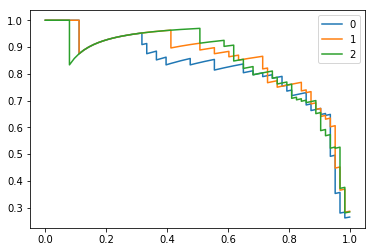

In [74]:
pr_curves.append(precision_recall_curve(y_test, y_test_prob[:, 1]))
for pr_curve in pr_curves:
    plt.plot(pr_curve[1], pr_curve[0])
plt.legend(range(len(pr_curves)))

In [66]:
# ROC curve
rocs = []  # reset 

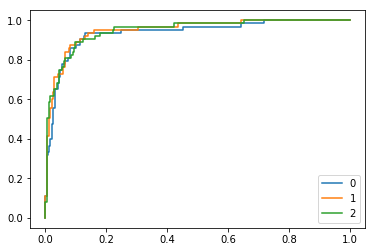

In [75]:
rocs.append(roc_curve(y_test, y_test_prob[:, 1]))
for roc in rocs:
    plt.plot(roc[0], roc[1])
plt.legend(range(len(rocs)))

In [ ]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [ ]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,:].applymap(utils.list2str))

---
---
# Neural Nets

**Data Prep**

In [ ]:
df_train.columns

In [ ]:
maxlen = [100,
          125,
          50,
          100]

In [ ]:
x_train_text = utils.Dataframe_Proc.df2text(df_train, df_train.columns[1:])
word2idx, idx2word = utils.Text_Proc.ngram_vocab_processor(x_train_text, ngram=1, min_count=2)
x_train = np.array(utils.Text_Proc.encode_texts(x_train_text, word2idx, maxlen=sum(maxlen)))

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train[:, None])

x_dev_text = utils.Dataframe_Proc.df2text(df_test, df_test.columns[1:])
x_dev = np.array(utils.Text_Proc.encode_texts(x_dev_text, word2idx, maxlen=x_train.shape[1]))

y_dev = enc.transform(y_test[:, None])

In [ ]:
x_train.shape

### NN Models

In [ ]:
tf.__version__

In [ ]:
# Clear flags
for key in [key for key in FLAGS._flags().keys()]:
    FLAGS.__delattr__(key)

# Both CNN and RNN
tf.flags.DEFINE_integer("embedding_dim", 64, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 1.0, "L2 regularization lambda (default: 0.0)")

# CNN parameter
tf.flags.DEFINE_string("filter_sizes", "2,2,2", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")

# RNN parameter
tf.flags.DEFINE_integer('hidden_size', 64, 'Hidden size of LSTM')
tf.flags.DEFINE_integer('num_layers', 1, 'Number of LSTM layers')

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
tf.flags.DEFINE_integer("log_every", 20, "Logs model on dev set after this many steps (default: 100)")

# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

# Fix Bugs 
tf.app.flags.DEFINE_string('f', '', 'kernel')

FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        model = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(word2idx),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextCNN_field_aware(sequence_lengths=maxlen,
#                                     num_classes=y_train.shape[1],
#                                     vocab_size=len(word2idx),
#                                     embedding_size=FLAGS.embedding_dim,
#                                     filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
#                                     num_filters=FLAGS.num_filters,
#                                     l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN(sequence_length=sum(maxlen),
#                         num_classes=y_train.shape[1],
#                         vocab_size=len(word2idx),
#                         embedding_size=FLAGS.embedding_dim,
#                         hidden_size=FLAGS.hidden_size,
#                         num_layers=FLAGS.num_layers,
#                         l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN_field_aware(sequence_lengths=maxlen,
#                                     num_classes=y_train.shape[1],
#                                     vocab_size=len(word2idx),
#                                     embedding_size=FLAGS.embedding_dim,
#                                     hidden_size=FLAGS.hidden_size,
#                                     num_layers=FLAGS.num_layers,
#                                     l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN_attention(sequence_length=sum(maxlen),
#                         num_classes=y_train.shape[1],
#                         vocab_size=len(word2idx),
#                         embedding_size=FLAGS.embedding_dim,
#                         hidden_size=FLAGS.hidden_size,
#                         num_layers=FLAGS.num_layers,
#                         l2_reg_lambda=FLAGS.l2_reg_lambda)


        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        # optimizer = tf.train.GradientDescentOptimizer(1e-3)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(model.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))

        if 'CNN' in model.__class__.__name__:
            name = "CNN_{}_{}_".format(FLAGS.embedding_dim, FLAGS.num_filters)
        elif 'RNN' in model.__class__.__name__:
            name = "RNN_{}_{}_{}_".format(FLAGS.embedding_dim, FLAGS.hidden_size, FLAGS.num_layers)


        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", name + timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", model.loss)
        acc_summary = tf.summary.scalar("accuracy", model.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        # vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: FLAGS.dropout_keep_prob,
                model.batch_size: len(x_batch)
            }

            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            if step % FLAGS.log_every == 0:
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: 1.0,
                model.batch_size: len(x_batch)
            }

            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)

            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

        #
        feed_dict = {
            model.input_x: x_dev,
            model.input_y: y_dev,
            model.dropout_keep_prob: 1.0,
            model.batch_size: len(x_dev)
        }
        y_dev_pred = sess.run([model.predictions], feed_dict=feed_dict)
#         y_dev_pred, alpha = sess.run([model.predictions, model.alpha], feed_dict=feed_dict)

In [ ]:
utils.my_classification_report(y_test, y_dev_pred[0])

In [ ]:
model = "TextRNN_field_aware"
output = output_report(y_test, y_dev_pred[0])
output.to_csv("CI/" + model +'.csv', header=False)

---------

## Classification Model

## Use findings and impression to predict present and pass

In [ ]:
df['history'][1]

In [ ]:
#for PAST without inconsistency
fields = [
    'history',
    'findings',
    'comparison',
    'impression',
]
foo = df[~df['Past'].isnull() & df['Count'] != 1].sample(frac=1)
df_train = foo.iloc[:1240]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[1240:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print(x_train.shape)
print(x_test.shape)

In [ ]:
#for PRESENT
fields = [
    'history', 
    'findings', 
    'comparison',
    'impression',
]
#'history', 'impression', 'findings', 'comparison'
foo = df[~df['Present'].isnull()].sample(frac=1)
foo = foo.loc[foo['Present']!=0, :]
df_train = foo.iloc[:1100]
y_train = np.array(df_train['Present'].astype(int))
df_test = foo.iloc[1100:]
y_test = np.array(df_test['Present'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=2)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Left'].isnull() & df['Left'] != 0].sample(frac=1)
df_train = foo.iloc[:210]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[210:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Right'].isnull() & df['Right'] != 0].sample(frac=1)
df_train = foo.iloc[:200]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[200:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

### run classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
clf = LinearSVC(C=1, loss='squared_hinge')
#clf = SVC()
#clf = LogisticRegression(C=3)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [ ]:
x_train.shape

In [ ]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

In [ ]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [ ]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
fields = [
    'Past',
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,fields].applymap(utils.list2str))

---
# Semi - Supervised Learning

## Prepare data

### Labeled Data

In [ ]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df = df[CORE_COL]
df_labeled = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

### Unlabeled Data

In [ ]:
filename = 'Data/2011-2016.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ORDERED_NAMES + discardField]
foo.sort()
CORE_COL = ORDERED_NAMES + foo
df_unlabeled = df[CORE_COL]
# df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

----

In [ ]:
#for PAST
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
# labeled data
df_labeled = utils.null2empty(df_labeled, fields)
foo = df_labeled[~df_labeled['Past'].isnull() & df_labeled['Past'] != 0].sample(frac=1, random_state=1)
df_train_labeled = foo.iloc[:1220]
y_train_labeled = np.array(df_train_labeled['Past'].astype(int))
y_train_labeled[y_train_labeled==-1] = 0 # turn -1 to 0
df_test = foo.iloc[1220:]
y_test = np.array(df_test['Past'].astype(int))
y_test[y_test==-1] = 0 # turn -1 to 0
obj = utils.Df2TFIDF()
obj.fit(df_train_labeled, fields, ngram=5, min_count=5)
output_train_labeled = obj.transform(df_train_labeled, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train_labeled = hstack([foo['bow_tfidf'] for foo in output_train_labeled.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train_labeled.shape
print x_test.shape
# unlabeled data
df_unlabeled = utils.null2empty(df_unlabeled, fields)
# obj = utils.Df2TFIDF()
# obj.fit(df_train_unlabeled, fields, ngram=5, min_count=5)
output_train_unlabeled = obj.transform(df_unlabeled, fields)
x_train_unlabeled = hstack([foo['bow_tfidf'] for foo in output_train_unlabeled.itervalues()])
print x_train_unlabeled.shape

In [ ]:
x_train = vstack([x_train_labeled, x_train_unlabeled])
y_train = np.append(y_train_labeled, np.ones(x_train_unlabeled.shape[0], dtype=int) * -1)

In [ ]:
from sklearn.semi_supervised import LabelPropagation
semi_clf = LabelPropagation(kernel='rbf', gamma=20, n_jobs=-1)
semi_clf.fit(x_train.toarray(), y_train)

In [ ]:
y_train_pred = semi_clf.predict(x_train_labeled.toarray())
y_test_pred = semi_clf.predict(x_test.toarray())
results = pd.concat([utils.my_classification_report(y_train_labeled, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)